In [48]:
import trackpy as tp 
import pims
import glob
import numpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import bmc
from tqdm import trange
import astropy.units as u
import astropy.constants as c

In [18]:
x10 = 9.51/13
x20 = 9.51/24
x40 = 9.51/57
fps = 30

In [21]:
def onion_path(onion, flow):
    path = "../data/onion_%s/Onion_%s_20x*"%(onion, flow)
    return glob.glob(path)

folder_paths = glob.glob("../data/onion_4/*")
onion_4 = onion_path("4", "bulk")

def all_velocity(t):
    all_vel = np.array([])
    for i in np.unique(t["particle"]):
        all_vel = np.append(all_vel, np.mean(bmc.particle_velocity(t, i, x20, fps)[0]))
    return all_vel

def all_viscosity(t):
    all_visc = np.array([])
    for i in np.unique(t["particle"]):
        all_visc = np.append(all_visc, np.mean(bmc.viscosity(t, i, x20, fps)))
    return all_visc

def radius(t):
    R_gyration = t["size"].values
    mean_R_gyration = np.mean(R_gyration)
    r = np.sqrt(5/3 * mean_R_gyration**2)
    return r

In [23]:
all_velocities = np.array([])
all_viscosities= np.array([])
all_radii = np.array([])
for folder in folder_paths:
    path = folder + "/*.bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)
    all_velocities = np.append(all_velocities, all_velocity(t))
    all_viscosities= np.append(all_viscosities, all_viscosity(t))
    all_radii = np.append(all_radii, radius(t))

Frame 443: 5 trajectories present.


20.459274041856432

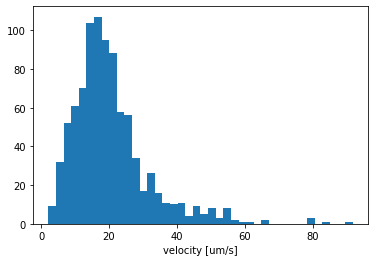

In [24]:
plt.figure()
cnts,_,_ = plt.hist(all_velocities, bins=40, log=0)#, bins=np.linspace(0,13))
plt.xlabel("velocity [um/s]");
velo = np.mean(all_velocities)
velo

6.424444048487947

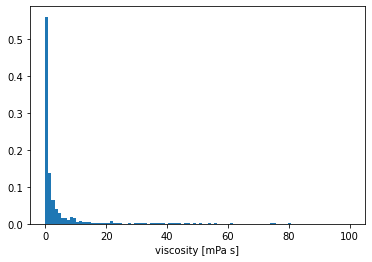

In [25]:
plt.figure()
cnts,_,_ = plt.hist(all_viscosities, bins=np.linspace(0,100, 100), density=1)#, bins=np.linspace(0,13))
plt.xlabel("viscosity [mPa s]");
visc = np.mean(all_viscosities)
visc

2.933235359518904

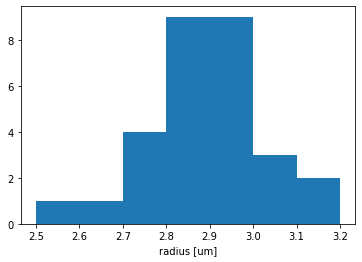

In [41]:
plt.figure()
cnts,_,_ = plt.hist(all_radii, bins=np.linspace(2.5, 3.2, 8))#, bins=np.linspace(0,13))
plt.xlabel("radius [um]");
radii = np.mean(all_radii)
radii

In [55]:
def work(velocity, viscosity, radius):
    v = velocity
    n = viscosity
    r = radius
    x = 200 #units um
    return 3*np.pi*n*r*v*x

total_work = work(velo, visc, radii)
total_work

726731.1995307367

In [56]:
def motors(work):
    free_e = 57.5 * 1000 #* 6.0221409e+23
    return np.round(work / free_e)

motors(total_work)

13.0